In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import warnings
from sklearn.ensemble import ExtraTreesRegressor
warnings.filterwarnings('ignore')

sns.set()

## Data Preprocessing

In [20]:
# y: whether the client subscribed a term deposit?
bank = pd.read_csv("bank/bank-full.csv", delimiter = ';')
bank['y'] = np.where(bank['y'] == 'yes', 1, 0)

X = bank.iloc[:, :-1]
y = pd.DataFrame(bank.iloc[:, -1])
X


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown


In [21]:
y = np.ravel(y)

### Exploratory Data Analysis

#### Analysis of each dummies

In [22]:
job = pd.DataFrame({'y': bank.groupby('job')['y'].mean()})
job.reset_index(inplace=True)

marital = pd.DataFrame({'y': bank.groupby('marital')['y'].mean()})
marital.reset_index(inplace=True)

education = pd.DataFrame({'y': bank.groupby('education')['y'].mean()})
education.reset_index(inplace=True)

default = pd.DataFrame({'y': bank.groupby('default')['y'].mean()})
default.reset_index(inplace=True)

housing = pd.DataFrame({'y': bank.groupby('housing')['y'].mean()})
housing.reset_index(inplace=True)

loan = pd.DataFrame({'y': bank.groupby('loan')['y'].mean()})
loan.reset_index(inplace=True)

contact_type = pd.DataFrame({'y': bank.groupby('contact')['y'].mean()})
contact_type.reset_index(inplace=True)

previous_outcome = pd.DataFrame({'y': bank.groupby('poutcome')['y'].mean()})
previous_outcome.reset_index(inplace=True)

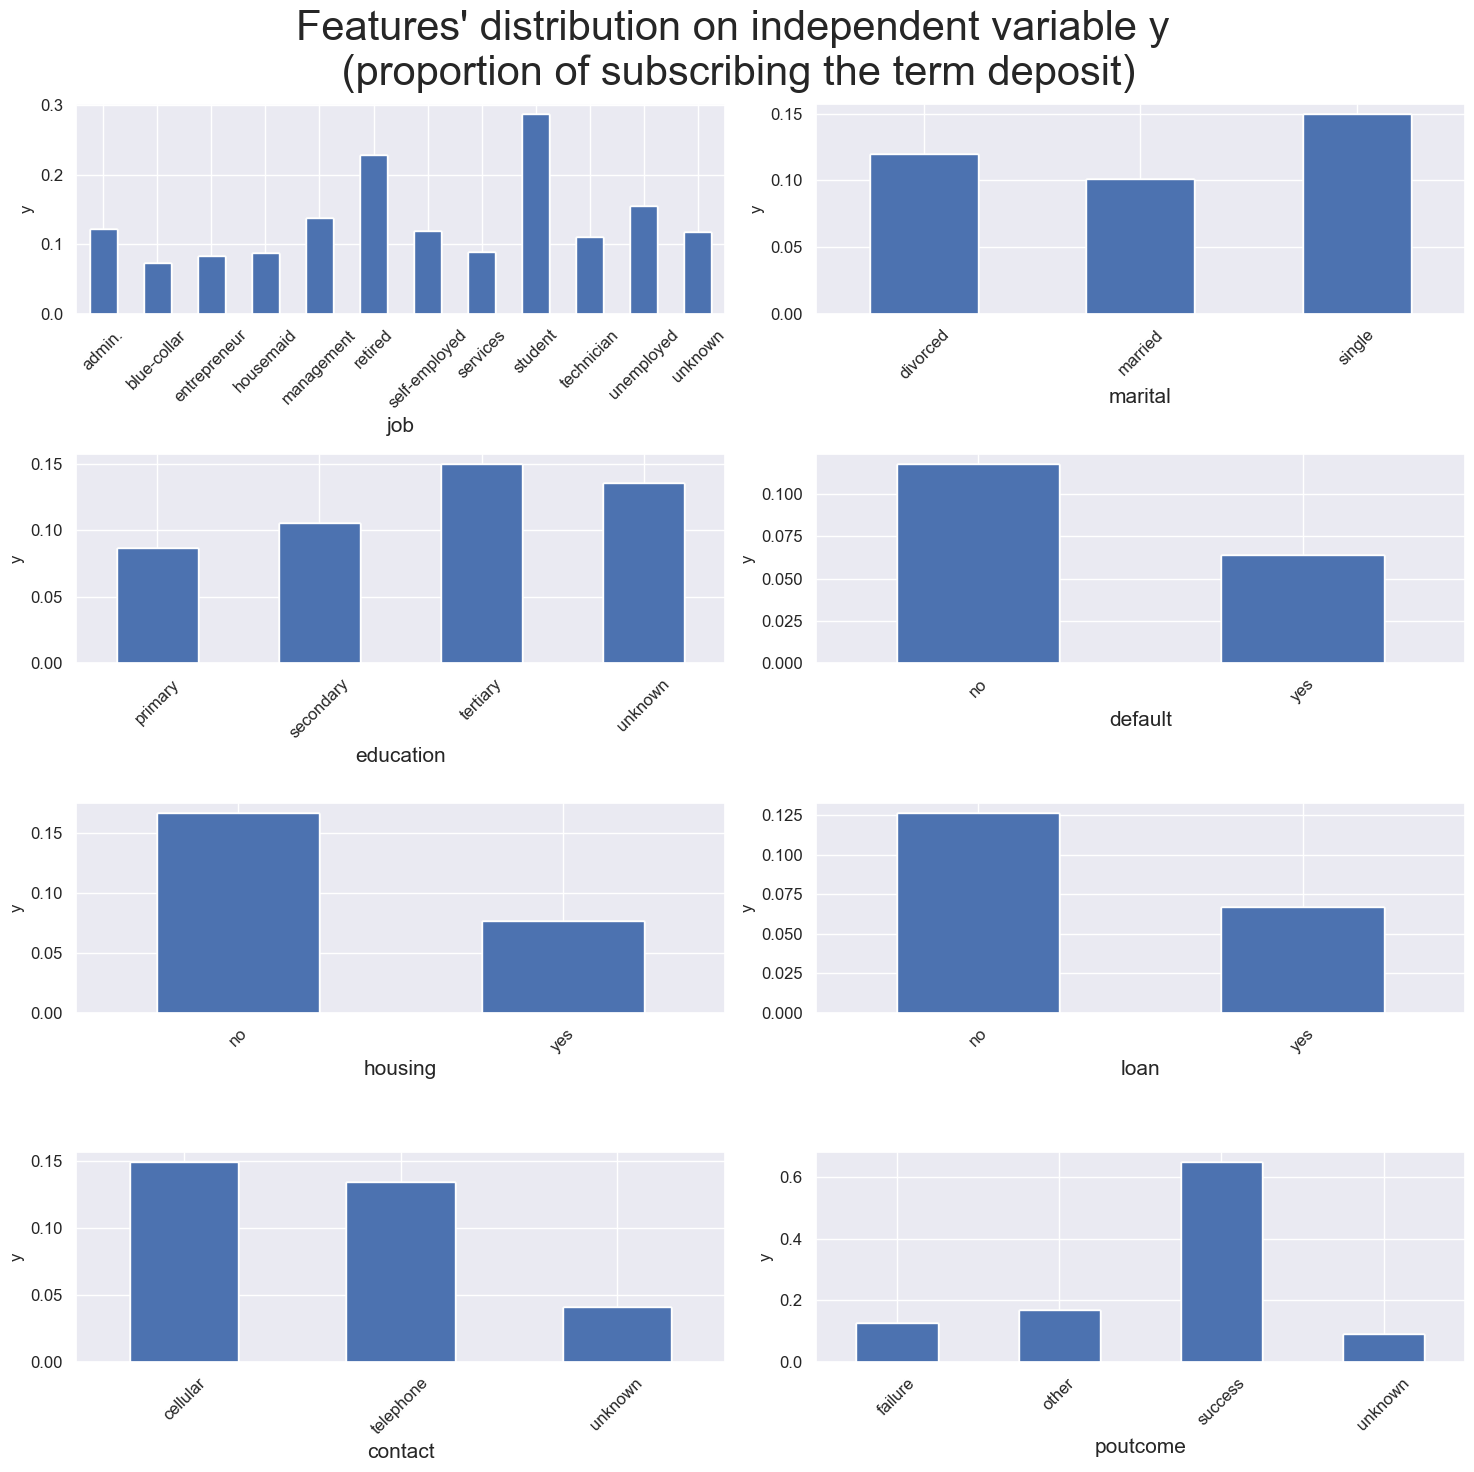

In [23]:
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(15,15))

axes = (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8)
features = [job, marital, education, default, housing, loan, contact_type, previous_outcome]
fea_var_name = ['job','marital','education','default','housing','loan','contact','poutcome']
k = 0
for i in range(4):
    for j in range(2):
        for feature, axis, name in zip(features, axes, fea_var_name):
            ax = feature.plot(x = name, y = 'y', ax = axis, kind = 'bar', 
                         stacked=True, legend = False, rot = 45, ylabel = 'y', fontsize = 12)
            ax.set_xlabel(xlabel = name, fontsize = 15)
            k += 1

figure.suptitle(
    "Features' distribution on independent variable y\n (proportion of subscribing the term deposit)",
    fontsize = 30)
figure.tight_layout()

- job: **students** and **retired people** are more willing to subscribe a term deposit.

- education: people with **higher education** tend to subscribe a term deposit.

- default, housing, loan: people **without financial burden** tend to subscribe a term deposit.

- previous outcome: people who **subscribed in the previous** marketing campaign tend to subscribe a term deposit.

#### Missing Value Processing

In [24]:
bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

#### Catagorical Variable Processing (One-hot encoding)

In [25]:
# one-hot encoding: job, martial, education, default, housing, loan, contact, poutcome, y

In [26]:
age = X[['age']]

job = X[['job']]
job = pd.get_dummies(job, drop_first = True)             # job "admin." is dropped

marital = X[['marital']]
marital = pd.get_dummies(marital, drop_first = True)     # marital "divorced" is dropped

education = X[['education']]
education = pd.get_dummies(education, drop_first = True) # education "primary" is dropped

default = X[['default']]
default = pd.DataFrame(np.where(default['default'].astype(str) == "no", 0, 1))
default.columns = ['default']

balance = X[['balance']]

housing = X[['housing']]
housing = pd.DataFrame(np.where(housing['housing'].astype(str) == "no", 0, 1))
housing.columns = ['housing']

loan = X[['loan']]
loan = pd.DataFrame(np.where(loan['loan'].astype(str) == "no", 0, 1))
loan.columns = ['loan']

contact = X[['contact']]
contact = pd.get_dummies(contact, drop_first = True)     # Cellular is dropped
contact

day_previous = X[['duration', 'campaign', 'pdays', 'previous']]

poutcome = X[['poutcome']]
poutcome = pd.get_dummies(poutcome, drop_first = True)   # Failure is dropped

# Encoded DataFrame: X_
X_ = pd.concat([age, job, marital, education, default, balance, housing, loan, 
               contact, day_previous, poutcome], axis = 1).reset_index(drop = True)

#### Split the DataSet

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(X_, y, test_size = 0.3, random_state = 1)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state = 1)

X_train_val = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_val)]).values
y_train_val = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_val)]).values

#### Feature Scaling

In [28]:
cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

for var in cols:
    X_train[[var]] = ss.fit_transform(X_train[[var]])
    X_val[[var]] = ss.transform(X_val[[var]])
    X_test[[var]] = ss.transform(X_test[[var]])


In [29]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values


In [30]:
X_.columns

Index(['age', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default', 'balance',
       'housing', 'loan', 'contact_telephone', 'contact_unknown', 'duration',
       'campaign', 'pdays', 'previous', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

In [31]:
# getting feature importance to the target variable.
selection = ExtraTreesRegressor()
selection.fit(X_.values, y)
selection.feature_importances_

array([0.12114445, 0.01306717, 0.00646594, 0.00594135, 0.01552861,
       0.00761537, 0.00782123, 0.01062337, 0.00614896, 0.01799055,
       0.00771835, 0.00192547, 0.01704115, 0.01360051, 0.01888228,
       0.01490144, 0.0082499 , 0.00301003, 0.11799562, 0.01665601,
       0.01647429, 0.01280607, 0.01437997, 0.29535454, 0.06561671,
       0.03272128, 0.02221294, 0.00574751, 0.09381781, 0.00854113])

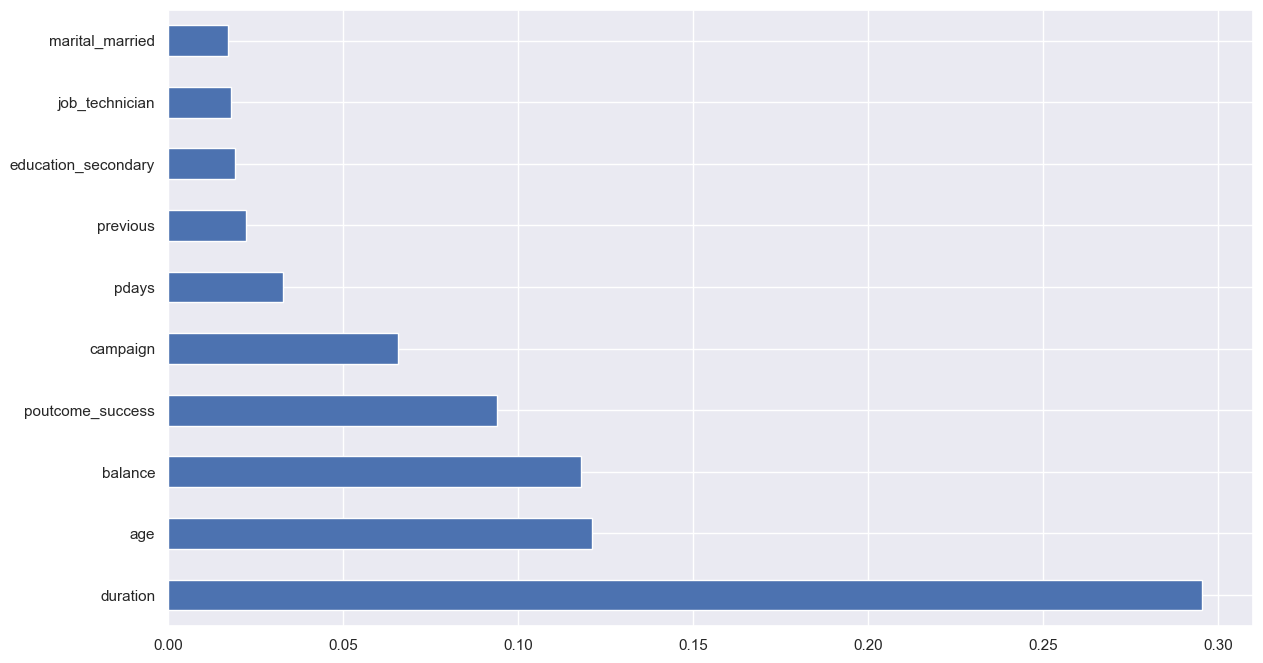

In [32]:
plt.figure(figsize = (14,8))
feat_importances = pd.Series(selection.feature_importances_ ,index = X_.columns)
feat_importances.nlargest(10).plot(kind="barh")
plt.show()

#### Analysis of y

In [33]:
bank['y'].value_counts()

0    39922
1     5289
Name: y, dtype: int64

Because the numbers of subscription and non-subscription differ a lot, this classification problem is not symmetric. (Too many observations that fell into the category of not subscribing.) This will generate **Accuracy Paradox**, so we should not use accuracy to measure our model's performance.

**Accuracy Paradox** in this case:

Most of the people were categorized as 0 (didn't subscribe), so any model can just predict most of the observations as 0 to get high accuracy. However, this prediction will not give us any insightful interpretation.

To aviod accuracy paradox, we can use other two metrices to measure our models.

- **Recall**: correct positive prediction observations divided by actual positive observations.
  $$Recall = \frac{true\ positive}{true\ positive + false\ negative}$$

- **Precision**: correct positive prediction observations divided by observations that were predicted to be positive.
  $$Precision = \frac{true\ positive}{true\ positive + false\ positive}$$

Whether we choose recall or precision as our performance index depends on the tolerance of false positive and false negative with respect to our topic. For instance, if we are going to detect a disease, we prefer lower proportion of false negative, as it is dangerous that a patient is examined as negative yet with disease actually. In this case, our purpose is to find as many true positive observations as possible, so we would choose **recall** as our valuation metric.

In the bank marketing situation, we want to find the potential customers who will subscribe our term deposit. By predicting whether a customer has the potential to subscribe, we can investigate our target audience and focus our advertizements to them. We don't want to waste our advertisement cost on people who actually won't subscribe our program (false positive). Therefore, we choose precision as our performance measurement.

## Modelling

In [34]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix


In [35]:
def get_score(model):
    print('-' * 30)
    print(f'{model}' + '\n')
    print(f'confusion matrix: \n{confusion_matrix(y_val, model.predict(X_val))}\n')
    print(f'accuracy = {accuracy_score(y_val, model.predict(X_val))}')
    print(f'recall = {recall_score(y_val, model.predict(X_val))}')
    print(f'precision = {precision_score(y_val, model.predict(X_val))}')
    print('-' * 30)

In [36]:
models = []

### Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
logistic_reg = LogisticRegression(random_state = 1)

logistic_reg.fit(X_train, y_train)
models.append(logistic_reg)

get_score(logistic_reg)

------------------------------
LogisticRegression(random_state=1)

confusion matrix: 
[[5888  156]
 [ 494  244]]

accuracy = 0.9041580654674137
recall = 0.33062330623306235
precision = 0.61
------------------------------


### K Nearest Neighbors

In [38]:
from sklearn.neighbors import KNeighborsClassifier
K_NN = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
K_NN.fit(X_train, y_train)

models.append(K_NN)

get_score(K_NN)

------------------------------
KNeighborsClassifier()

confusion matrix: 
[[5819  225]
 [ 459  279]]

accuracy = 0.8991447950457092
recall = 0.3780487804878049
precision = 0.5535714285714286
------------------------------


### Naive Bayes

In [39]:
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(X_train, y_train)

models.append(NB)

get_score(NB)

------------------------------
GaussianNB()

confusion matrix: 
[[5196  848]
 [ 343  395]]

accuracy = 0.8243880861102919
recall = 0.535230352303523
precision = 0.3177795655671762
------------------------------


### Decision Tree

In [40]:
from sklearn.tree import DecisionTreeClassifier
Tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
Tree.fit(X_train, y_train)

models.append(Tree)

get_score(Tree)

------------------------------
DecisionTreeClassifier(criterion='entropy', random_state=0)

confusion matrix: 
[[5560  484]
 [ 392  346]]

accuracy = 0.8708345620760838
recall = 0.46883468834688347
precision = 0.41686746987951806
------------------------------


### Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators = 15, criterion = 'entropy', random_state = 1)
RF.fit(X_train, y_train)

models.append(RF)

get_score(RF)

------------------------------
RandomForestClassifier(criterion='entropy', n_estimators=15, random_state=1)

confusion matrix: 
[[5823  221]
 [ 449  289]]

accuracy = 0.9012090828664111
recall = 0.3915989159891599
precision = 0.5666666666666667
------------------------------


It is hard to determine which model is better, so we run them on test set again to determine the best one.

## Testing the final model

In [42]:
def train_final(model):
    model.fit(X_train_val, y_train_val)
    print('-' * 30)
    print(f'{model}')
    print(f'confusion matrix: \n{confusion_matrix(y_test, model.predict(X_test))}\n')
    print(f'accuracy = {accuracy_score(y_test, model.predict(X_test))}')
    print(f'recall = {recall_score(y_test, model.predict(X_test))}')
    print(f'precision = {precision_score(y_test, model.predict(X_test))}')
    print('-' * 30)

In [43]:
for model in models:
    train_final(model)

------------------------------
LogisticRegression(random_state=1)
confusion matrix: 
[[5969    0]
 [ 810    3]]

accuracy = 0.8805662046593925
recall = 0.0036900369003690036
precision = 1.0
------------------------------
------------------------------
KNeighborsClassifier()
confusion matrix: 
[[5969    0]
 [ 813    0]]

accuracy = 0.8801238572692421
recall = 0.0
precision = 0.0
------------------------------
------------------------------
GaussianNB()
confusion matrix: 
[[5035  934]
 [ 439  374]]

accuracy = 0.7975523444411678
recall = 0.46002460024600245
precision = 0.28593272171253825
------------------------------
------------------------------
DecisionTreeClassifier(criterion='entropy', random_state=0)
confusion matrix: 
[[5969    0]
 [ 813    0]]

accuracy = 0.8801238572692421
recall = 0.0
precision = 0.0
------------------------------
------------------------------
RandomForestClassifier(criterion='entropy', n_estimators=15, random_state=1)
confusion matrix: 
[[5969    0]
 [ 811 

It is shown that the over-fitting problem is severe in most models.
We can see that among these models, only Naive Bayesien Classifier performs with reasonable recall and precision, so we choose this as our final model. We can predict whether a customer would subscribe our term deposit program with recall = 0.46 and precision = 0.28. 

## Data Source
  [Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
  In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.

  Available at: 
  - [pdf] http://hdl.handle.net/1822/14838
  - [bib] http://www3.dsi.uminho.pt/pcortez/bib/2011-esm-1.txt